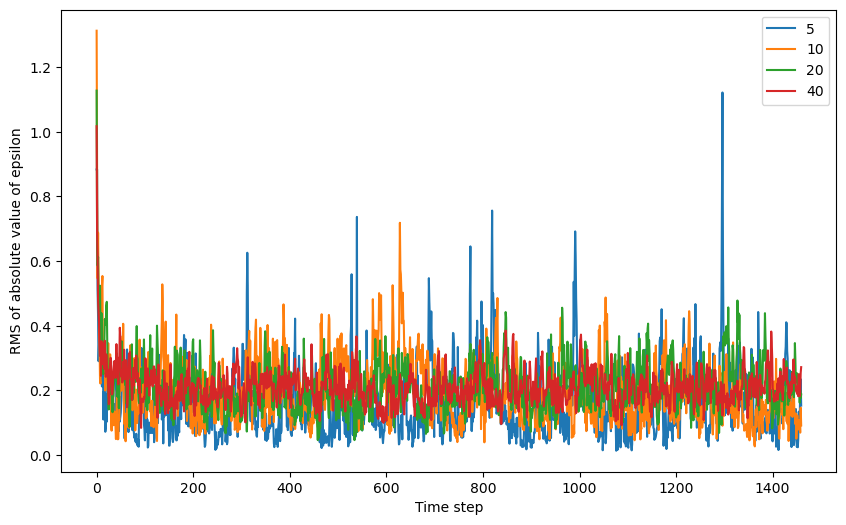

In [30]:
import numpy as np
import pandas as pd
from scipy.linalg import inv, sqrtm
from numpy import identity as eye
import sys
import matplotlib.pyplot as plt

class Datagenerater:
    def __init__(self, F=8.0, N = 40,dt=0.05):
        self.F = F
        self.N = N
        self.dt = dt
        self.u = np.full(N, F) + np.random.rand(N)

    def L96(self, u):
        F, N = self.F, self.N
        f = np.zeros(N)
        for k in range(2, N-1):
            f[k] = (u[k+1] - u[k-2]) * u[k-1] - u[k] + F
        f[0] = (u[1] - u[N-2]) * u[N-1] - u[0] + F
        f[1] = (u[2] - u[N-1]) * u[0] - u[1] + F
        f[N-1] = (u[0] - u[N-3]) * u[N-2] - u[N-1] + F
        return f

    def Model(self, u):
        dt = self.dt
        s1 = self.L96(u)
        s2 = self.L96(u + s1 * dt / 2)
        s3 = self.L96(u + s2 * dt / 2)
        s4 = self.L96(u + s3 * dt)
        du = u + (s1 + 2 * s2 + 2 * s3 + s4) * (dt / 6)
        return du

    def Data_generate(self, Time_Step=1460):
        t_data, o_data = [], []
        u = self.u

        for _ in range(Time_Step):
            u = self.Model(u)

        for i in range(Time_Step):
            u = self.Model(u)
            t_data.append(u)
        df_t = pd.DataFrame(t_data)
        df_t.to_csv('t_data_6.csv')
        t_data = np.array(t_data)

        for i in range(Time_Step):
            noisy_observation = t_data[i, :] + np.random.randn(self.N)
            o_data.append(noisy_observation)
        df_o = pd.DataFrame(o_data)
        df_o.to_csv('o_data_6.csv')
        
class L96Model:
    def __init__(self, N = 40):
        self.F = 8.0
        self.N = N
        self.dt = 0.05
        self.days = 365
        self.day_steps = int(0.20 / self.dt)
        self.time_step = self.days * self.day_steps
        self.delta = 0.001
        self.ls_time_step = [i for i in range(self.time_step)]
        self.tuning = 1.1
        self.IN = np.eye(self.N)
        self.H = np.eye(self.N)
        self.R = np.eye(self.N)
    
    def L96(self, x):
        N = self.N
        F = self.F
        dxdt = np.zeros((N))
        for i in range(2, N-1):
            dxdt[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i] + F
        dxdt[0] = (x[1] - x[N-2]) * x[N-1] - x[0] + F
        dxdt[1] = (x[2] - x[N-1]) * x[0] - x[1] + F
        dxdt[N-1] = (x[0] - x[N-3]) * x[N-2] - x[N-1] + F
        return dxdt
    
    def Rk4(self, xold):
        dt = self.dt
        k1 = self.L96(xold)
        k2 = self.L96(xold + k1 * dt / 2.)
        k3 = self.L96(xold + k2 * dt / 2.)
        k4 = self.L96(xold + k3 * dt)
        xnew = xold + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return xnew
    
    def RMS(self, error):
        return np.sqrt(np.mean(error**2))
    
    def trRMS(self, x):
        return np.sqrt(x / self.N)
    
    def run_simulation(self):
        df_x_true = pd.read_csv('t_data_6.csv', header=0, index_col=0)
        x_true = df_x_true.values
        df_y = pd.read_csv('o_data_6.csv', header=0, index_col=0)
        y = df_y.values
        
        x_a = x_true[1,:]
        Pa = 25 * np.eye(self.N)  # a = 5 を Pa = a**2 * I として解釈
        
        forecast, analysis, trPa = [], [], []
        error_f, error_a, error_o = [], [], []
        
        for i in range(self.time_step):
            x_f = self.Rk4(x_a)
            forecast.append(x_f)
            JM = np.zeros((self.N, self.N))
            for j in range(self.N):
                JM[:, j] = (self.Rk4(x_a + self.delta * self.IN[:, j]) - self.Rk4(x_a)) / self.delta
            
            Pf = self.tuning * JM @ Pa @ JM.T
            K = Pf @ self.H.T @ np.linalg.pinv(self.H @ Pf @ self.H.T + self.R)
            x_a = x_f + K @ (y[i, :] - self.H @ x_f)
            analysis.append(x_a)
            Pa = (eye(self.N) - K @ self.H) @ Pf
            trPa.append(self.trRMS(np.trace(Pa)))
        
        return self.plot_results(forecast, analysis, trPa, error_f, error_a, error_o, x_true, y)
    
    def plot_results(self, forecast, analysis, trPa, error_f, error_a, error_o, x_true, y):
        analysis = np.array(analysis)
        
        for i in range(self.time_step):
            a = analysis[i, :]
            t = x_true[i, :]
            epsilon_a = a - t
            error_a.append(self.RMS(epsilon_a))
        
        return error_a
    
if __name__ == "__main__":
    Ns = [5, 10, 20, 40]
    ls_time_step = [i for i in range(1460)]

    plt.figure(figsize=(10, 6))

    for Number in Ns:
        # データ生成
        generate = Datagenerater(N=Number)
        generate.Data_generate()

        # モデルの実行
        model = L96Model(N=Number)
        result = model.run_simulation()

        plt.plot(ls_time_step, result, label=f'{Number}')

    plt.xlabel('Time step')
    plt.ylabel('RMS of absolute value of epsilon')

    plt.legend()

    plt.show()
